# Loading the tflite model

In [1]:
model_path = r"posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"

In [2]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [3]:
output_details

[{'name': 'MobilenetV1/heatmap_2/BiasAdd',
  'index': 87,
  'shape': array([ 1,  9,  9, 17]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'MobilenetV1/offset_2/BiasAdd',
  'index': 90,
  'shape': array([ 1,  9,  9, 34]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'MobilenetV1/displacement_fwd_2/BiasAdd',
  'index': 84,
  'shape': array([ 1,  9,  9, 32]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'MobilenetV1/displacement_bwd_2/BiasAdd',
  'index': 81,
  'shape': array([ 1,  9,  9, 32]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

# Test with an Image

In [4]:
import cv2
img = cv2.imread('person.jpg')

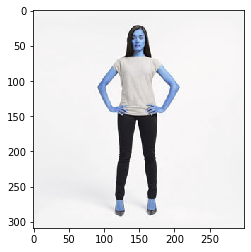

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img)

# Get Output

In [44]:
input_shape = tuple(input_details[0]['shape'][1:-1])

# scale to [-1, 1]
adjust_range = np.vectorize(lambda x: (x - 128)/128)

scaled_input = adjust_range(cv2.resize(img, input_shape))
scaled_input_as_tensor = tf.convert_to_tensor(scaled_input.reshape(1, *scaled_input.shape), np.float32)

In [45]:
# Test model on random input data.
# input_shape = input_details[0]['shape']
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
# input_data = scaled_input_as_tensor
interpreter.set_tensor(input_details[0]['index'], scaled_input_as_tensor)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
# output_data = interpreter.get_tensor(output_details[0]['index'])

# Process Ouput

In [128]:
output_details[0]['index']

87

In [8]:
body_parts = [ 
    "NOSE",
    "LEFT_EYE",
    "RIGHT_EYE",
    "LEFT_EAR",
    "RIGHT_EAR",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_ELBOW",
    "RIGHT_ELBOW",
    "LEFT_WRIST",
    "RIGHT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE"
]

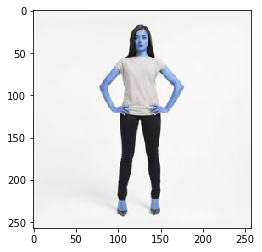

In [39]:
test = scaled_input_as_tensor.numpy()
# plt.imshow(test,)
# plt.imshow(test[0].astype(np.int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NOSE 0.9952904185796244
LEFT_EYE 0.9843516804566396
RIGHT_EYE 0.982699921889153
LEFT_EAR 0.7949696322619798
RIGHT_EAR 0.6942858982612163
LEFT_SHOULDER 0.941758327222536
RIGHT_SHOULDER 0.9826050143621204
LEFT_ELBOW 0.8368327776051129
RIGHT_ELBOW 0.8636783601678748
LEFT_WRIST 0.9125310515328646
RIGHT_WRIST 0.7199244717680664
LEFT_HIP 0.9605511661748011
RIGHT_HIP 0.9199020679065902
LEFT_KNEE 0.8755894802751572
RIGHT_KNEE 0.8079370011806
LEFT_ANKLE 0.8541187995888248
RIGHT_ANKLE 0.7759941212622635


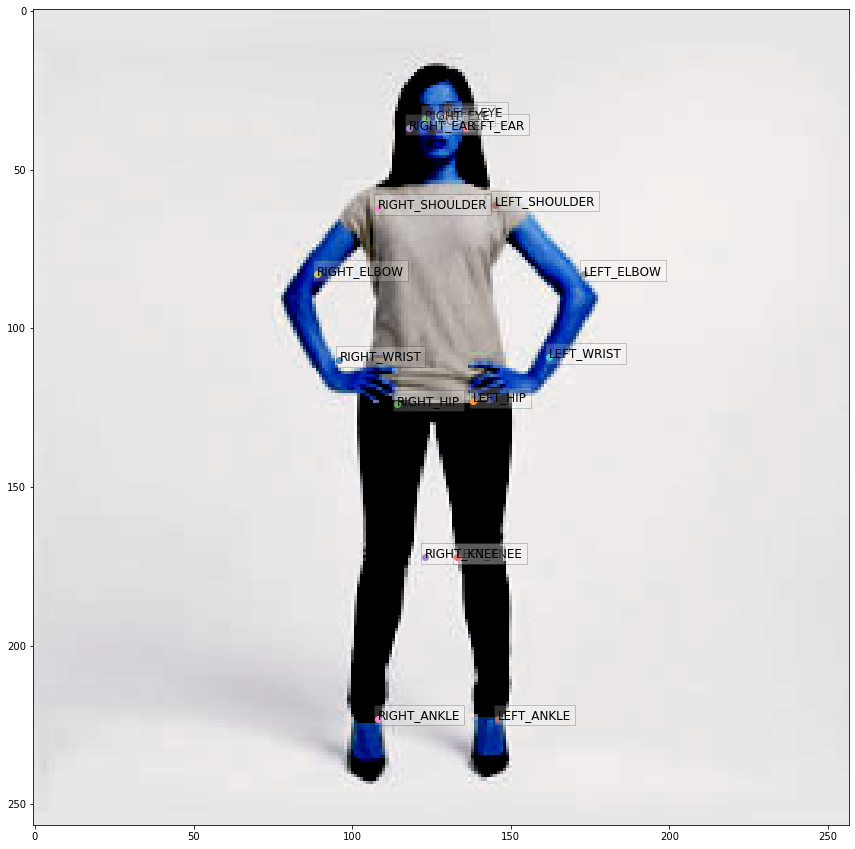

In [55]:
'''
Reference Code:
https://github.com/tensorflow/examples/blob/master/lite/examples/posenet/android/posenet/src/main/java/org/tensorflow/lite/examples/posenet/lib/Posenet.kt
'''

import numpy as np

plt.figure(figsize=(15,15))
plt.imshow(scaled_input)
heatmap = interpreter.get_tensor(output_details[0]['index'])
offsets = interpreter.get_tensor(output_details[1]['index'])

num_keypoints = heatmap.shape[-1]
img_height, img_width = scaled_input.shape[:-1]

for keypoint in range(num_keypoints):
    heatmap_for_keypoint = heatmap[0,:,:,keypoint]
    
    # Get index of max coords from heatmap
    i, j = np.unravel_index(heatmap_for_keypoint.argmax(), heatmap_for_keypoint.shape)
    
    sigmoid = lambda x: 1/(1 + np.exp(-x)) 
    confidence = sigmoid(heatmap[0, i, j, keypoint])
    
    y = i / (heatmap.shape[1] - 1) * img_height + offsets[0,i,j,keypoint]
    x = j / (heatmap.shape[2] - 1) * img_width + offsets[0,i,j,keypoint+num_keypoints]
    
    y = int(y)
    x = int(x)
    print(body_parts[keypoint], confidence)
    plt.text(x, y, body_parts[keypoint], bbox=dict(facecolor='white', alpha=0.2), fontsize=12)
    plt.scatter(x, y)

In [10]:
plt.imshow(output_data[0,:,:,11])

NameError: name 'output_data' is not defined

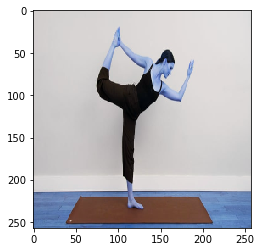

In [21]:
plt.imshow(scaled_input)

In [30]:
output_data[0,:,:,11]

array([[-10.436783 , -10.807783 , -11.469342 , -12.348707 , -13.32308  ,
        -11.767577 , -12.196229 , -14.47324  , -12.111179 ],
       [-10.0738735, -10.908148 , -11.584009 , -11.228915 , -10.456223 ,
        -10.8096895, -11.173056 , -12.648217 ,  -9.99819  ],
       [ -9.0387335,  -8.270085 ,  -8.969101 , -10.3194685,  -9.916219 ,
         -9.381687 ,  -9.075569 ,  -8.807498 , -10.488172 ],
       [ -8.672519 ,  -9.69547  , -10.221165 , -10.28175  ,  -7.5252514,
         -7.0625286,  -8.790529 ,  -8.60666  ,  -9.991703 ],
       [ -8.726252 , -12.275596 , -10.641254 , -11.11042  ,  -9.244887 ,
         -8.817442 , -10.247177 ,  -7.3509035,  -8.924967 ],
       [ -8.775082 , -11.854358 , -10.628264 , -11.705958 , -11.465076 ,
        -10.863074 , -10.676092 ,  -8.771388 ,  -8.699848 ],
       [ -8.829869 , -10.683459 ,  -9.551323 ,  -9.316471 ,  -9.372441 ,
         -9.617159 , -10.460394 ,  -9.212459 ,  -8.616674 ],
       [ -9.154846 ,  -9.058008 ,  -7.7627754,  -7.248377 ,  -